In [1]:
using
    DataFrames,
    Arrow,
    CSV,
    Plots,
    PlotlyJS

In [2]:
include("shared/CommonConstants.jl")
include("shared/CommonFunctions.jl")
include("shared/DataInit.jl")
using
    .CommonFunctions,
    .CommonConstants,
    .DataInit

In [3]:
NOTEBOOK_DIRS = NamedTuple(
    name=>joinpath("..", path) for (name, path) in pairs(DIRS)
)

(fund = "..\\data/mutual-funds", currency = "..\\data/currencies", equity = "..\\data/equities", map = "..\\data/mappings")

In [4]:
currency_file = joinpath(
    NOTEBOOK_DIRS.currency, "combined/currency_rates.arrow"
)

"..\\data/currencies\\combined/currency_rates.arrow"

Load in and check the currencies used.

In [5]:
currency_data = Arrow.Table(currency_file) |> DataFrame
first(currency_data,2)

Row,cur_code,date,spot_bid,forward_bid,spot_mid,forward_mid,spot_ask,forward_ask
,String,Date,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,AED,1995-06-30,3.6725,3.6715,3.6728,3.67235,3.673,3.6732
2,AED,1995-07-31,3.6726,3.6716,3.673,3.6726,3.6734,3.6736


In [6]:
n_currencies_by_date = groupby(
    currency_data, :date
) |> df->combine(
    df, :cur_code => (x->length(unique(x))) => :n_currencies
) |> df->sort(df, :date);

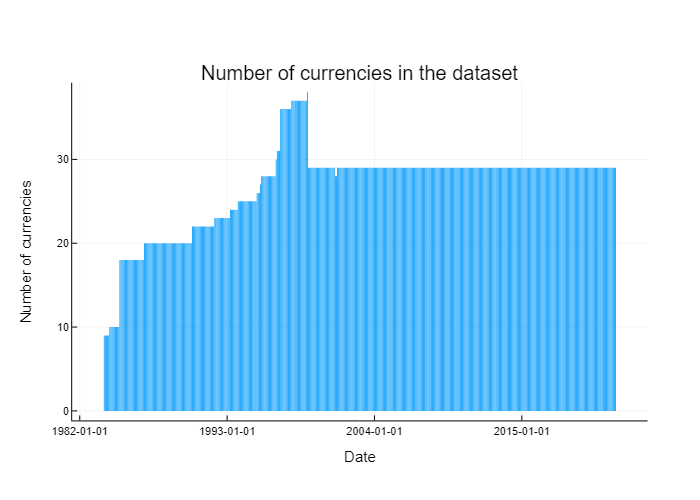

In [8]:
plotlyjs()
Plots.plot(
    n_currencies_by_date.date,
    n_currencies_by_date.n_currencies,
    legend=false,
    seriestype=:bar,
    linecolor=nothing,
    size=(1000, 400),
    xlabel="Date",
    ylabel="Number of currencies",
    title="Number of currencies in the dataset"
)

In [12]:
first(n_currencies_by_date,3)

Row,date,n_currencies
,Date,Int64
1,1983-10-31,9
2,1983-11-30,9
3,1983-12-31,9


In [14]:
first_date = minimum(currency_data.date)
pre_euro_date = n_currencies_by_date[n_currencies_by_date.n_currencies .== maximum(n_currencies_by_date.n_currencies), :date]
last_date = maximum(currency_data.date)

println("First date is $first_date, pre-Euro date is $pre_euro_date and last date is $last_date.")

First date is 1983-10-31, pre-Euro date is [Dates.Date("1998-12-31")] and last date is 2021-12-31.


In [18]:
currencies_snapshots = DataFrame[]
push!(currencies_snapshots, currency_data[currency_data.date .== first_date, :])
push!(currencies_snapshots, currency_data[currency_data.date .== pre_euro_date, :])
push!(currencies_snapshots, currency_data[currency_data.date .== last_date, :])

3-element Vector{DataFrame}:
 9×8 DataFrame
 Row │ cur_code  date        spot_bid    forward_bid  spot_mid    forward_mid  spot_ask    forwar ⋯
     │ String    Date        Float64?    Float64?     Float64?    Float64?     Float64?    Float6 ⋯
─────┼─────────────────────────────────────────────────────────────────────────────────────────────
   1 │ BEF       1983-10-31   53.49        53.44       53.51         53.48      53.53        53.5 ⋯
   2 │ CHF       1983-10-31    2.1405       2.1294      2.1412        2.1306     2.142        2.1
   3 │ DEM       1983-10-31    2.6295       2.6197      2.63          2.6203     2.6305       2.6
   4 │ FRF       1983-10-31    8.001        8.017       8.0025        8.0197     8.004        8.0
   5 │ GBP       1983-10-31    0.668449     0.668896    0.668673      0.66921    0.668896     0.6 ⋯
   6 │ HKD       1983-10-31    7.798        7.798       7.7995        7.802      7.801        7.8
   7 │ JPY       1983-10-31  233.9        233.24      233.95    

In [24]:
mapping = CSV.read(
    joinpath(NOTEBOOK_DIRS.map, "currency_to_country.csv"),
    DataFrame
)
first(mapping,2)

Row,currency_code,country_code,start_date,end_date
,String3,String3,Date,Date
1,AED,ARE,missing,missing
2,ATS,AUT,missing,1999-01-01


In [25]:
country_sets = Vector{Set{String}}(undef, length(currencies_snapshots))

3-element Vector{Set{String}}:
 #undef
 #undef
 #undef

In [27]:
country_sets = Vector{Set{String}}(undef, length(currencies_snapshots))
for (i, snapshot) in enumerate(currencies_snapshots)
    date = first(snapshot.date)
    country_sets[i] = Set{String}()
    for row in eachrow(mapping)
        !ismissing(row.start_date) && row.start_date > date && continue
        !ismissing(row.end_date) && row.end_date < date && continue
        if row.currency_code ∈ snapshot.cur_code
            push!(country_sets[i], row.country_code)
        end
    end
end


In [34]:
country_sets[2]

Set{String} with 36 elements:
  "FRA"
  "NLD"
  "KWT"
  "NOR"
  "HKG"
  "FIN"
  "CZE"
  "DNK"
  "IND"
  "AUT"
  "ARE"
  "ESP"
  "CHE"
  "ITA"
  "SGP"
  "IRL"
  "MEX"
  "SAU"
  "NZL"
  ⋮ 